# C S 342 Final Project

## Loading and Understanding the Dataset

In [66]:
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torchvision import datasets, transforms
from collections import Counter

from tqdm import tqdm

In [67]:
# Load dataset (the dataset was processed to only have 200x200 pixel images)

transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
])

data_dir = "ASL Alphabet Dataset"
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

print("Classes:", full_dataset.classes)
print("Total images:", len(full_dataset))

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
Total images: 166028


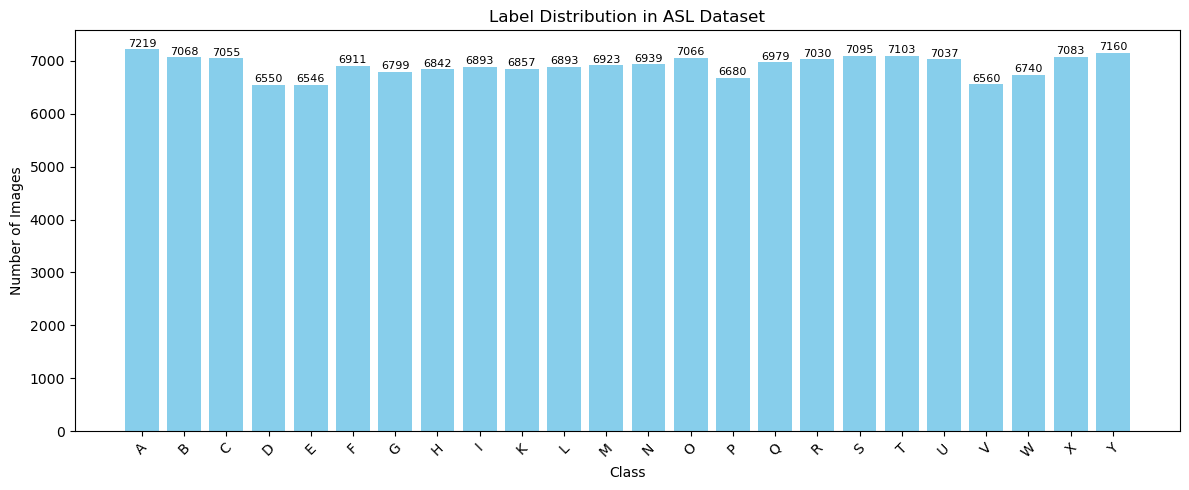

In [68]:
# Check dataset class distribution

label_counts = Counter(full_dataset.targets)
counts = list(label_counts.values())
classes = [full_dataset.classes[i] for i in label_counts.keys()]

plt.figure(figsize=(12, 5))
bars = plt.bar(classes, counts, color="skyblue")
plt.title("Label Distribution in ASL Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 10, str(height),
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [69]:
# Split dataset into train, validation, and test sets

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 116219, Val: 24904, Test: 24905


In [70]:
# Create DataLoaders

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

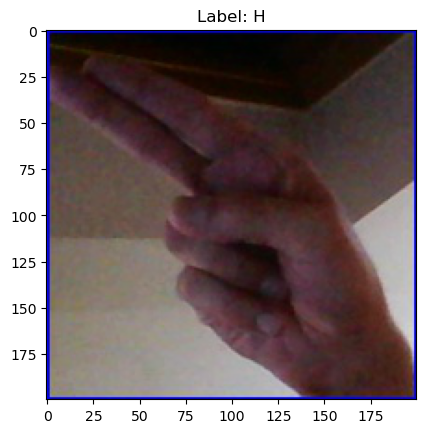

In [71]:
# Show a sample image

def imshow(img, title=""):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.title(title)
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(images[0], title=f"Label: {full_dataset.classes[labels[0]]}")

In [72]:
# Set device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [73]:
# Define training function

def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / len(dataloader.dataset)
    return epoch_loss, epoch_acc

In [74]:
# Define validation / testing function

def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / len(dataloader.dataset)
    return epoch_loss, epoch_acc

In [75]:
# Define our model

class ASLCNN(nn.Module):
    def __init__(self, num_classes):
        super(ASLCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 25 * 25, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [76]:
# Instantiate training parameters 

model = ASLCNN(num_classes=len(full_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [77]:
# Train and save best model

epochs = 10
best_val_acc = 0.0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Saved new best model.")



Epoch 1/10


100%|██████████| 3632/3632 [02:55<00:00, 20.70it/s]


Train Loss: 2.4769, Train Acc: 0.2297
Val   Loss: 1.4286, Val   Acc: 0.5250
✅ Saved new best model.

Epoch 2/10


100%|██████████| 3632/3632 [02:49<00:00, 21.44it/s]


Train Loss: 1.2249, Train Acc: 0.5971
Val   Loss: 0.6917, Val   Acc: 0.7861
✅ Saved new best model.

Epoch 3/10


100%|██████████| 3632/3632 [02:50<00:00, 21.26it/s]


Train Loss: 0.7121, Train Acc: 0.7780
Val   Loss: 0.4681, Val   Acc: 0.8564
✅ Saved new best model.

Epoch 4/10


100%|██████████| 3632/3632 [02:50<00:00, 21.36it/s]


Train Loss: 0.5913, Train Acc: 0.8214
Val   Loss: 0.4738, Val   Acc: 0.8549

Epoch 5/10


100%|██████████| 3632/3632 [02:50<00:00, 21.30it/s]


Train Loss: 0.5362, Train Acc: 0.8391
Val   Loss: 0.4318, Val   Acc: 0.8695
✅ Saved new best model.

Epoch 6/10


100%|██████████| 3632/3632 [02:48<00:00, 21.50it/s]


Train Loss: 0.5079, Train Acc: 0.8479
Val   Loss: 0.5413, Val   Acc: 0.8467

Epoch 7/10


100%|██████████| 3632/3632 [02:49<00:00, 21.44it/s]


Train Loss: 0.4970, Train Acc: 0.8518
Val   Loss: 0.4506, Val   Acc: 0.8640

Epoch 8/10


100%|██████████| 3632/3632 [02:49<00:00, 21.39it/s]


Train Loss: 0.4712, Train Acc: 0.8586
Val   Loss: 0.4196, Val   Acc: 0.8689

Epoch 9/10


100%|██████████| 3632/3632 [02:49<00:00, 21.44it/s]


Train Loss: 0.4682, Train Acc: 0.8598
Val   Loss: 0.3820, Val   Acc: 0.8797
✅ Saved new best model.

Epoch 10/10


100%|██████████| 3632/3632 [02:48<00:00, 21.56it/s]


Train Loss: 0.4392, Train Acc: 0.8662
Val   Loss: 0.3745, Val   Acc: 0.8836
✅ Saved new best model.


In [78]:
# Evaluate model on test set

model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"\n🧪 Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


C:\Users\ExoHorizon\AppData\Local\Temp\ipykernel_36652\2456452720.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))



🧪 Test Loss: 0.3811, Test Accuracy: 0.8834
